In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchinfo import summary

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

from tqdm.notebook import tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

import os
import shutil



In [2]:
NORMAL_PATH = "C:/Users/PC/Documents/0.Personal/FYP/FYP/Code/Train/1NonCOVID"
COVID_PATH = "C:/Users/PC/Documents/0.Personal/FYP/FYP/Code/Train/2COVID"
# CAP_PATH = "C:/Users/PC/Documents/FYP/FYP/Code/curated_data/train/3CAP"

DATA_PATH = "C:/Users/PC/Documents/0.Personal/FYP/FYP/Code/Train"


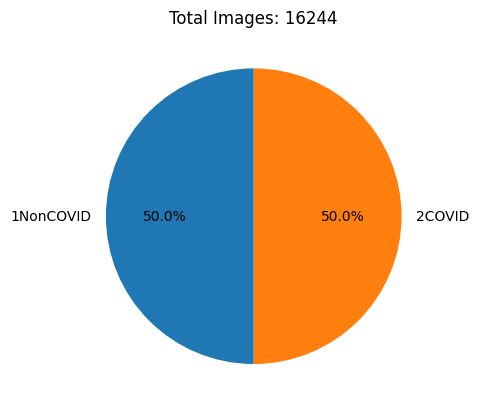

In [3]:
class_names = os.listdir(DATA_PATH)
image_count = {}
total = 0
for i in class_names:
    images_in_class = len(os.listdir(os.path.join(DATA_PATH,i)))
    image_count[i] = images_in_class
    total += images_in_class

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=False,
        autopct = '%1.1f%%',
        startangle=90)
ax1.set_title('Total Images: {}'.format(total))
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_1364\1001813832.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


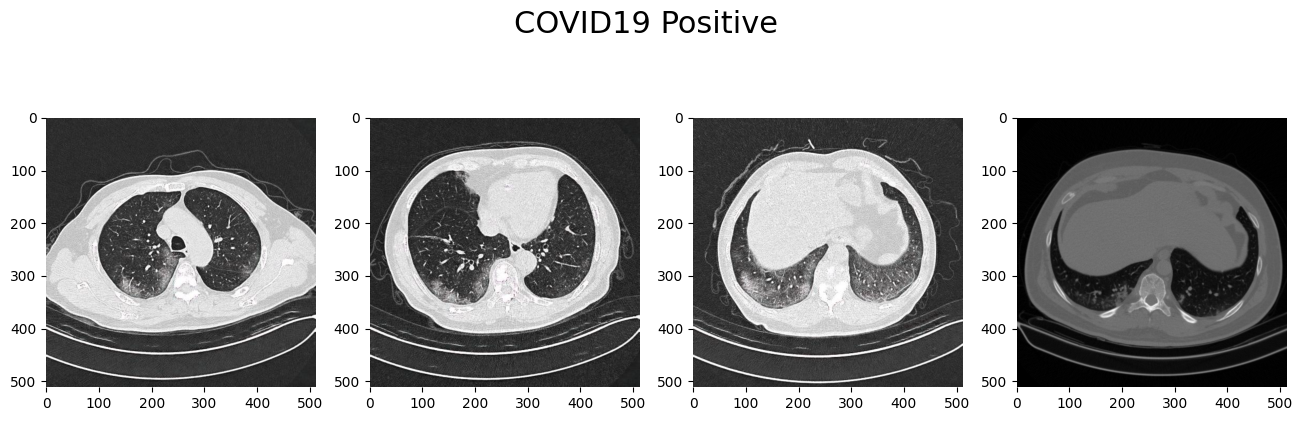

In [4]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Positive", size=22)
img_paths = os.listdir(COVID_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(COVID_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_1364\2599686391.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


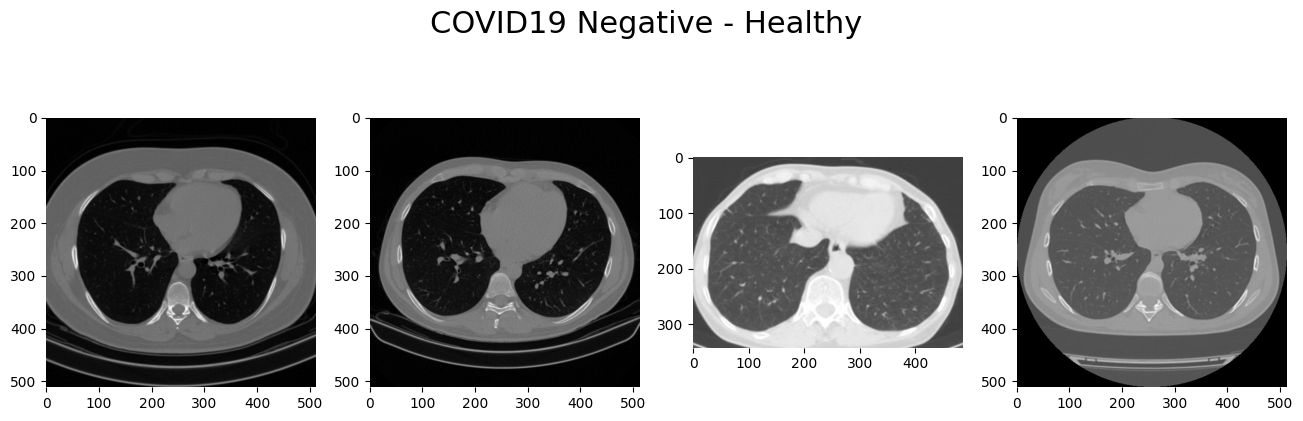

In [5]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Negative - Healthy", size=22)
img_paths = os.listdir(NORMAL_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(NORMAL_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

In [6]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
    #224 128
                                transforms.Resize((224,224)), #Resizes all images into same dimension
                                transforms.ColorJitter(brightness=0.2, contrast=0.5, saturation=0.1, hue=0.2),
                                transforms.GaussianBlur(kernel_size=(1,3), sigma=(0.1, 1.0)),
                                transforms.RandomAdjustSharpness(sharpness_factor=1.0),
                                transforms.RandomRotation(10), # Rotates the images upto Max of 10 Degrees
                                transforms.RandomHorizontalFlip(p=0.4), #Performs Horizantal Flip over images 
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    "val": transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.CenterCrop(224), #Performs Crop at Center and resizes it to 224x224
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}

In [17]:
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
    #224 128
                                transforms.Resize((224,224)), #Resizes all images into same dimension
                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
                                transforms.GaussianBlur(kernel_size=(1,3), sigma=(0.1, 0.7)),
                                transforms.RandomAdjustSharpness(sharpness_factor=0.4),
                                transforms.RandomRotation(10), # Rotates the images upto Max of 10 Degrees
                                transforms.RandomHorizontalFlip(p=0.4), #Performs Horizantal Flip over images 
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    "val": transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.CenterCrop(224), #Performs Crop at Center and resizes it to 224x224
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}

In [18]:
"""
IMPORTANT
Batch Size Changed 
"""


def load_split_train_test(datadir, valid_size = .3):
    train_data = datasets.ImageFolder(datadir, transform=data_transforms['train']) #Picks up Image Paths from its respective folders and label them
    test_data = datasets.ImageFolder(datadir, transform=data_transforms['val'])
    
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    
    dataset_size = {"train":len(train_idx), "val":len(test_idx)}
    train_sampler = SubsetRandomSampler(train_idx) # Sampler for splitting train and val images
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=4) # DataLoader provides data from traininng and validation in batches
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=4)
    
    return trainloader, testloader, dataset_size
    
trainloader, valloader, dataset_size = load_split_train_test(DATA_PATH, .3)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes
print(class_names)
print(data_sizes)

['1NonCOVID', '2COVID']
{'train': 11371, 'val': 4873}


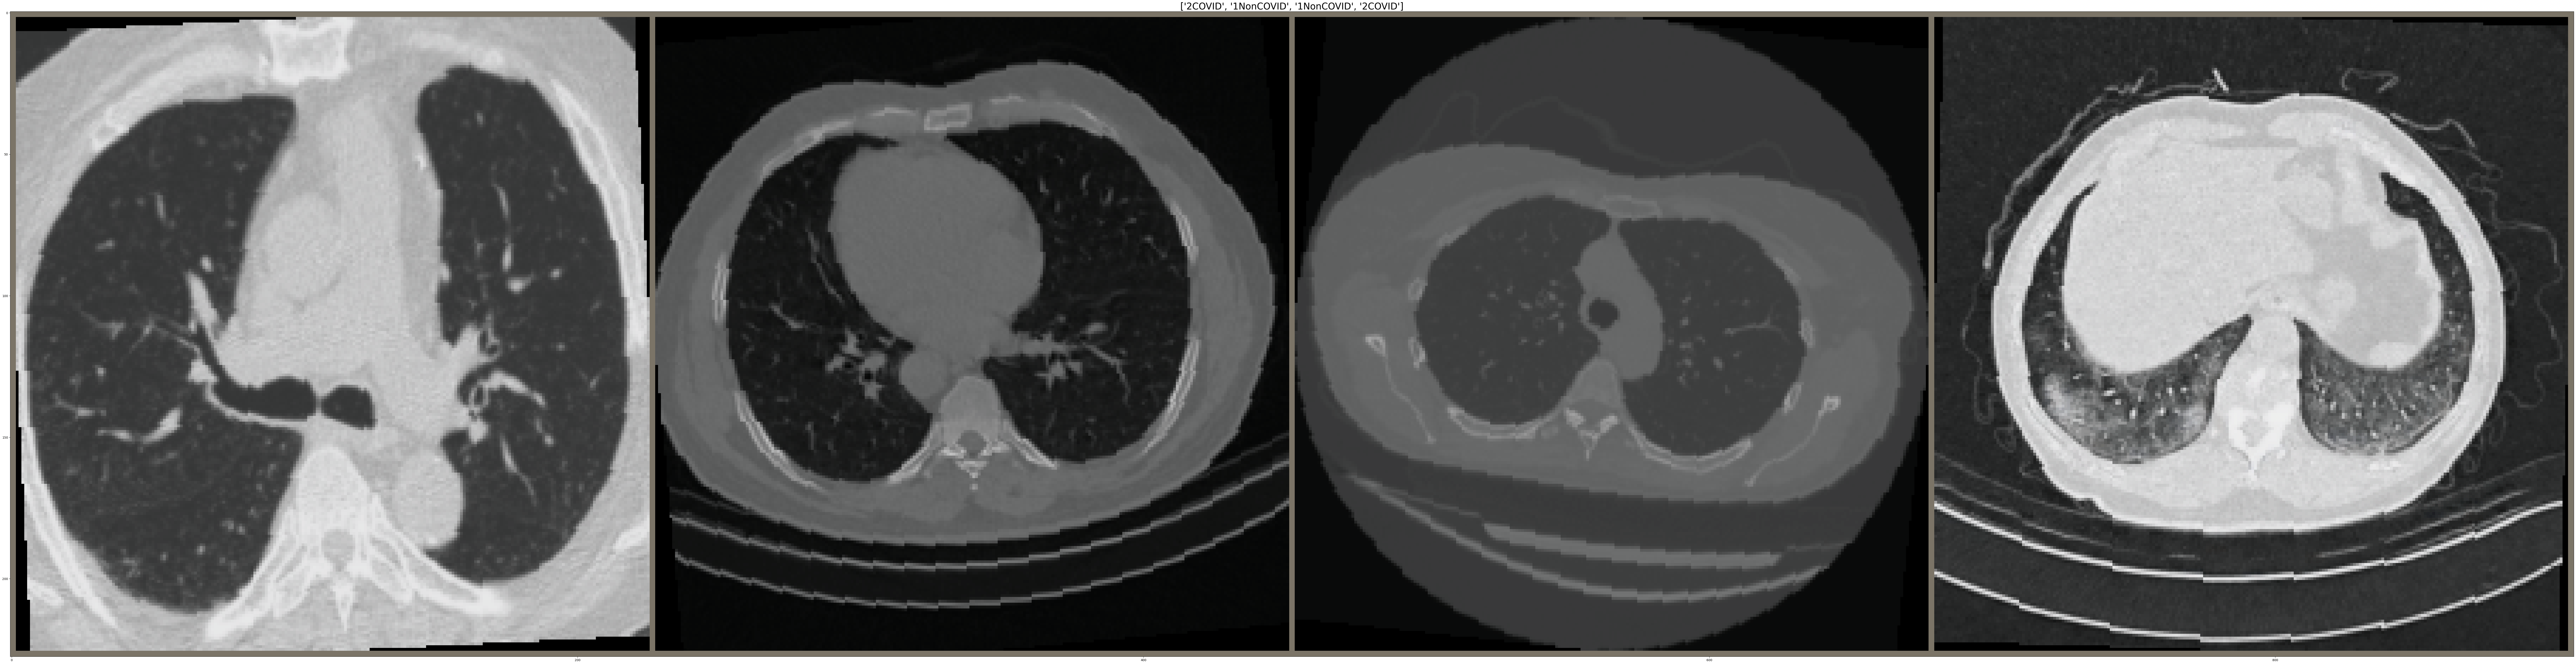

In [19]:
def imshow(inp, size =(150,150), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU...")
else:
    device = torch.device("cpu")
    print("Training on CPU...")

Training on GPU...


In [153]:
# def CNN_Model(pretrained=True):
#     ### DENSNET ###
#     #model = models.densenet121(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
#     #num_ftrs = model.classifier.in_features # Get the number of features output from CNN layer
#     #model.classifier = nn.Linear(num_ftrs, len(class_names)) # Overwrites the Classifier layer with custom defined layer for transfer learning
#     #model = model.to(device) # Transfer the Model to GPU if available
    
#     ### ResNet ###
#     model_resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
#     num_ftrs = model_resnet.fc.in_features
#     out_features = model_resnet.fc.out_features

#     for param in model_resnet.parameters():
#         param.requires_grad = False

#     #model_resnet.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=1)
#     #model_resnet.fc = nn.Identity()

#     model_resnet.fc = nn.Sequential(
#         nn.Linear(num_ftrs, 512),
#         nn.ReLU(),
#         nn.Linear(512, 256),
#         nn.ReLU(),
#         nn.Dropout(0.2),
#         nn.Linear(256, 2),
#         nn.ReLU()
#     )


#     # model_resnet.fc = nn.Sequential(
#     # nn.Linear(2048, 64),
#     # nn.ReLU(inplace=True),
#     # nn.Linear(64, 3)
#     # )
    
#     model_resnet = model_resnet.to(device)
    
#     return model_resnet

# model = CNN_Model(pretrained=True)

# # specify loss function (categorical cross-entropy loss)
# criterion = nn.CrossEntropyLoss() 

# # Specify optimizer which performs Gradient Descent
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning Scheduler

In [12]:
def CNN_Model(pretrained=True):    
    ### ResNet ###
    model_resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    num_ftrs = model_resnet.fc.in_features
    out_features = model_resnet.fc.out_features

    # for param in model_resnet.parameters():
    #     param.requires_grad = False

    model_resnet.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),

        nn.Dropout(p=0.5),
        nn.Linear(512, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),

        nn.Dropout(p=0.5),
        nn.Linear(64, 2),
        nn.ReLU(),
        )

    model_resnet = model_resnet.to(device)
    
    return model_resnet

model = CNN_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss() 

# Specify optimizer which performs Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning Scheduler

In [155]:
#print(model)
# summary(model, input_size=(2048,3,224,224), device=device)

In [156]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
24591234


In [157]:
train_loss = []
train_acc = []

val_loss = []
val_acc = []
val_kappa = []

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm(dataloaders[phase], desc=phase, leave=True):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    scheduler.step()

                # Variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                # val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                # epoch_kappa = np.mean(val_kappa)
                # print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                #     phase, epoch_loss, phase, epoch_acc, epoch_kappa))
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [14]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [160]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 1/10
----------


train:   0%|          | 0/178 [00:00<?, ?it/s]

train Loss: 0.4904 | train Accuracy: 0.7871


val:   0%|          | 0/77 [00:00<?, ?it/s]

val Loss: 0.4505 | val Accuracy: 0.8170
Val loss Decreased from inf to 0.4505 
Saving Weights... 

Epoch 2/10
----------


train:   0%|          | 0/178 [00:00<?, ?it/s]

train Loss: 0.4860 | train Accuracy: 0.7946


val:   0%|          | 0/77 [00:00<?, ?it/s]

val Loss: 0.4526 | val Accuracy: 0.8147

Epoch 3/10
----------


train:   0%|          | 0/178 [00:00<?, ?it/s]

train Loss: 0.4844 | train Accuracy: 0.7973


val:   0%|          | 0/77 [00:00<?, ?it/s]

val Loss: 0.4514 | val Accuracy: 0.8149

Epoch 4/10
----------


train:   0%|          | 0/178 [00:00<?, ?it/s]

train Loss: 0.4819 | train Accuracy: 0.7979


val:   0%|          | 0/77 [00:00<?, ?it/s]

val Loss: 0.4506 | val Accuracy: 0.8161

Epoch 5/10
----------


train:   0%|          | 0/178 [00:00<?, ?it/s]

train Loss: 0.4836 | train Accuracy: 0.7928


val:   0%|          | 0/77 [00:00<?, ?it/s]

val Loss: 0.4516 | val Accuracy: 0.8155

Epoch 6/10
----------


train:   0%|          | 0/178 [00:00<?, ?it/s]

train Loss: 0.4863 | train Accuracy: 0.7941


val:   0%|          | 0/77 [00:00<?, ?it/s]

val Loss: 0.4489 | val Accuracy: 0.8170
Val loss Decreased from 0.4505 to 0.4489 
Saving Weights... 

Epoch 7/10
----------


train:   0%|          | 0/178 [00:00<?, ?it/s]

train Loss: 0.4867 | train Accuracy: 0.7951


val:   0%|          | 0/77 [00:00<?, ?it/s]

val Loss: 0.4493 | val Accuracy: 0.8161

Epoch 8/10
----------


train:   0%|          | 0/178 [00:00<?, ?it/s]

train Loss: 0.4824 | train Accuracy: 0.7961


val:   0%|          | 0/77 [00:00<?, ?it/s]

val Loss: 0.4508 | val Accuracy: 0.8155

Epoch 9/10
----------


train:   0%|          | 0/178 [00:00<?, ?it/s]

train Loss: 0.4813 | train Accuracy: 0.7959


val:   0%|          | 0/77 [00:00<?, ?it/s]

val Loss: 0.4472 | val Accuracy: 0.8178
Val loss Decreased from 0.4489 to 0.4472 
Saving Weights... 

Epoch 10/10
----------


train:   0%|          | 0/178 [00:00<?, ?it/s]

train Loss: 0.4850 | train Accuracy: 0.7930


val:   0%|          | 0/77 [00:00<?, ?it/s]

val Loss: 0.4496 | val Accuracy: 0.8176

Training complete in 23m 52s
Best val loss: 0.4472


[0.49038847117486495, 0.48604938952151855, 0.4843762016906534, 0.48190842599670003, 0.4835860827396669, 0.4863366972340222, 0.4866896750099604, 0.48243067841627973, 0.48125315019170417, 0.4850065286089694]
[0.787089965702225, 0.794565121801073, 0.7972913552018293, 0.7979069562923226, 0.7928062615425204, 0.7941254067364348, 0.7950927798786387, 0.7961480960337701, 0.7958842669949873, 0.7929821475683757]


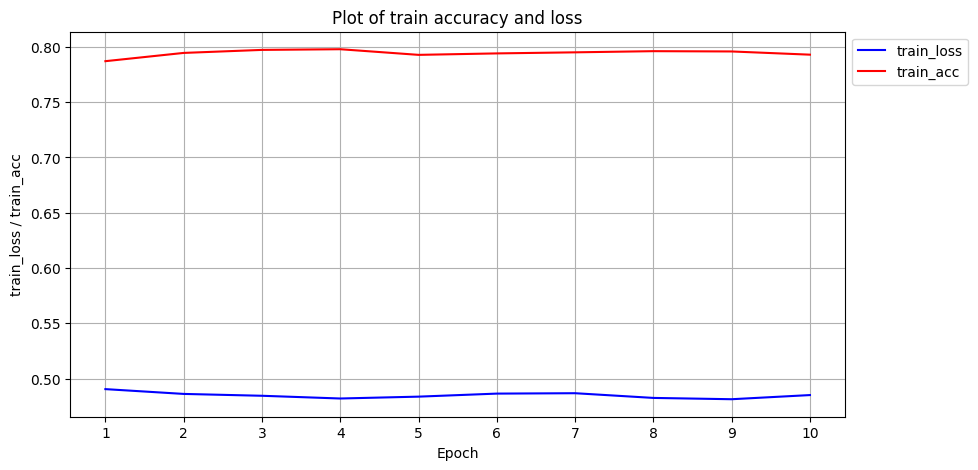

In [193]:
print(train_loss)
# print(train_acc)

x=range(1,len(train_loss)+1)

train_acc_log  = [train_acc.item() for train_acc in train_acc]

plt.figure(figsize=(10,5))
print(train_acc_log)
# Plot the graph
plt.plot(x, train_loss, color='blue', label="train_loss")
plt.plot(x, train_acc_log, color='red', label="train_acc")
plt.xticks(x)

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('train_loss / train_acc')
plt.title('Plot of train accuracy and loss')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid()
# Show the plot
plt.show()

[0.4505213501332062, 0.4526169821268329, 0.45139401241687444, 0.4505981012411292, 0.45161258823911243, 0.44892095922567554, 0.44927084913812526, 0.4507518092721927, 0.44720989651634, 0.4495629937942821]
[0.787089965702225, 0.794565121801073, 0.7972913552018293, 0.7979069562923226, 0.7928062615425204, 0.7941254067364348, 0.7950927798786387, 0.7961480960337701, 0.7958842669949873, 0.7929821475683757]


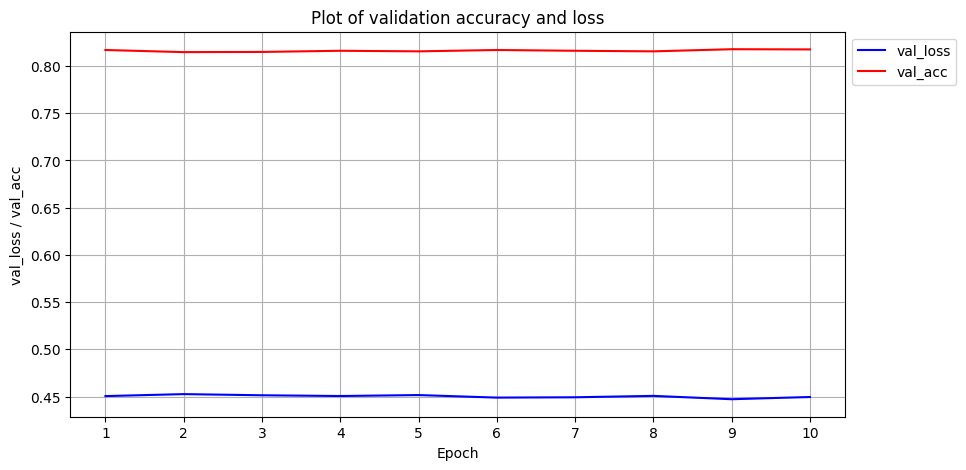

In [192]:
print(val_loss)
# print(train_acc)

x=range(1,len(val_acc)+1)

val_acc_log  = [val_acc.item() for val_acc in val_acc]

plt.figure(figsize=(10,5))
print(train_acc_log)
# Plot the graph
plt.plot(x, val_loss, color='blue', label="val_loss")
plt.plot(x, val_acc_log, color='red', label="val_acc")
plt.xticks(x)

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('val_loss / val_acc')
plt.title('Plot of validation accuracy and loss')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid()
# Show the plot
plt.show()

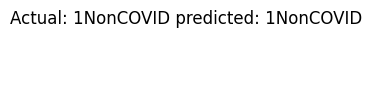

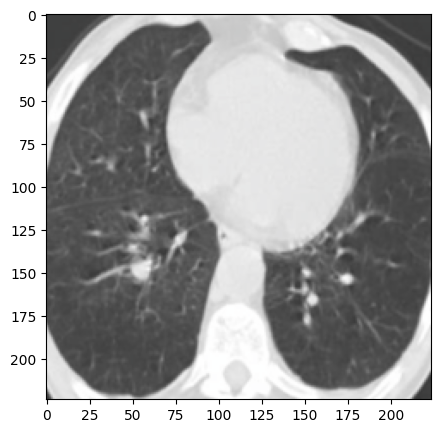

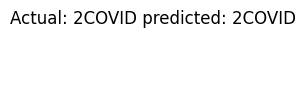

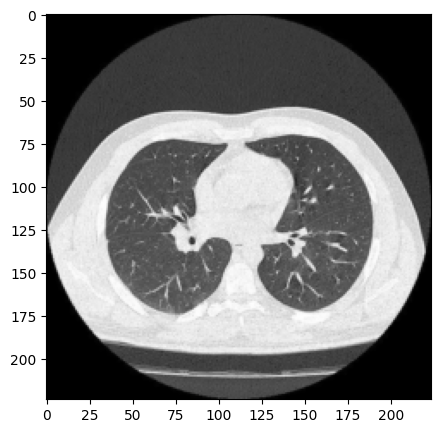

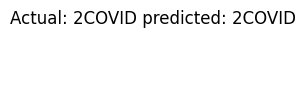

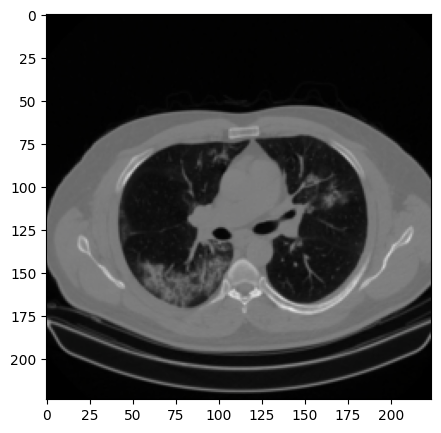

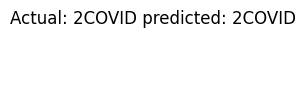

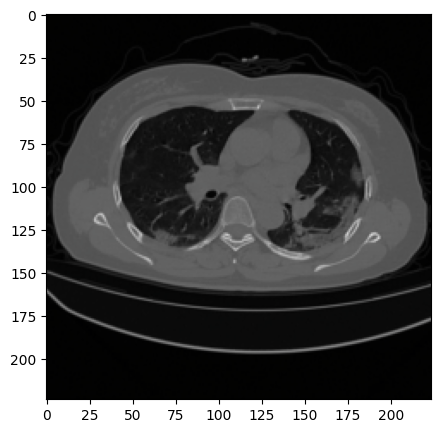

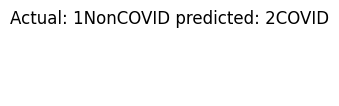

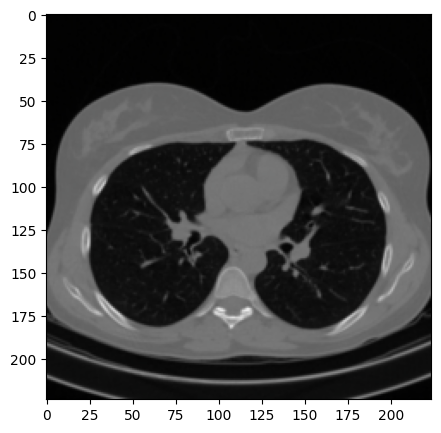

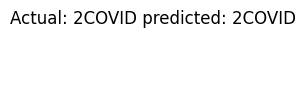

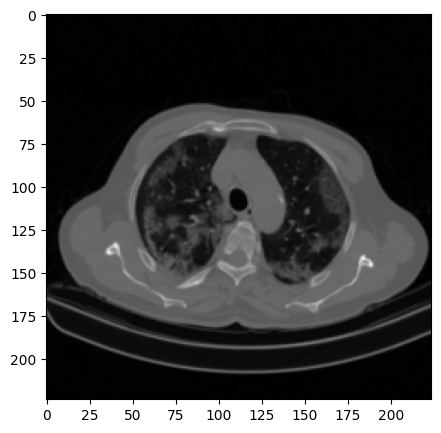

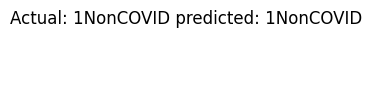

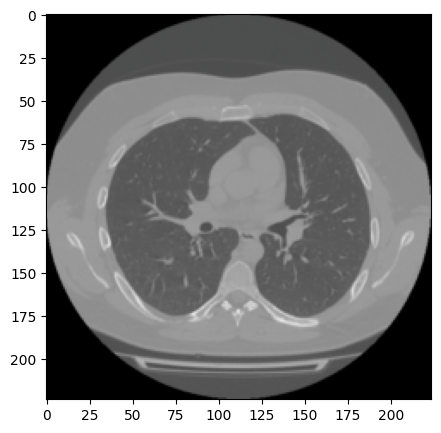

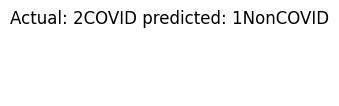

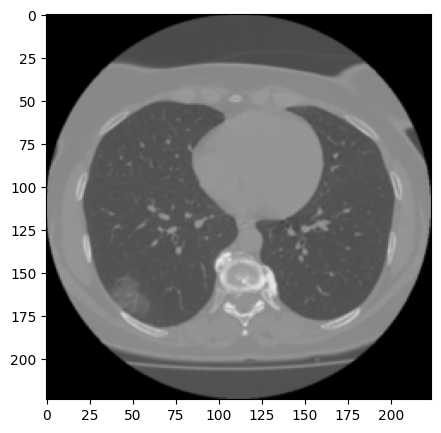

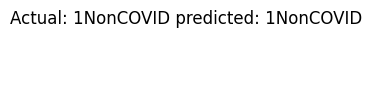

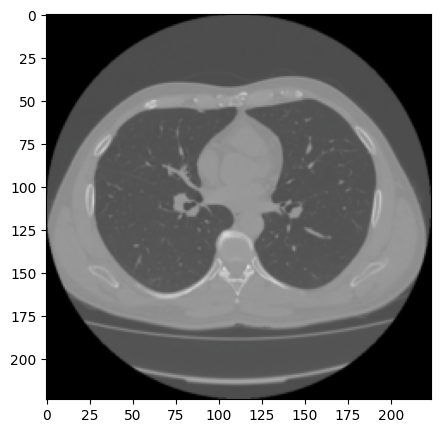

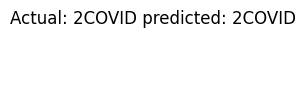

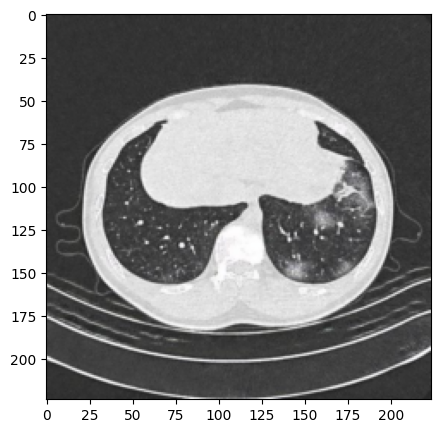

In [163]:
visualize_model(base_model)
plt.show()

In [18]:
NORMAL_TEST = "C:/Users/PC/Documents/0.Personal/FYP/FYP/Code/Train/1NonCOVID"
COVID_TEST = "C:/Users/PC/Documents/0.Personal/FYP/FYP/Code/Train/2COVID"
# CAP_PATH = "C:/Users/PC/Documents/FYP/FYP/Code/curated_data/train/3CAP"

TEST_DATA_PATH = "C:/Users/PC/Documents/0.Personal/FYP/FYP/Code/coivd-overfilled"

In [95]:
test_transforms = transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean_nums, std=std_nums)
])


test_image = datasets.ImageFolder(TEST_DATA_PATH, transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_image, batch_size=1)

In [17]:
eval_pred_list = []
eval_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(testloader, leave=True):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = base_model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        eval_pred_list.append(y_pred_tag.cpu().numpy())
        eval_true_list.append(y_batch.cpu().numpy())

  0%|          | 0/16244 [00:00<?, ?it/s]

NameError: name 'base_model' is not defined

In [167]:
eval_pred_list = [i[0] for i in eval_pred_list]
eval_true_list = [i[0] for i in eval_true_list]

In [168]:
print(classification_report(eval_true_list, eval_pred_list))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80      8122
           1       0.78      0.88      0.83      8122

    accuracy                           0.82     16244
   macro avg       0.82      0.82      0.81     16244
weighted avg       0.82      0.82      0.81     16244



In [29]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

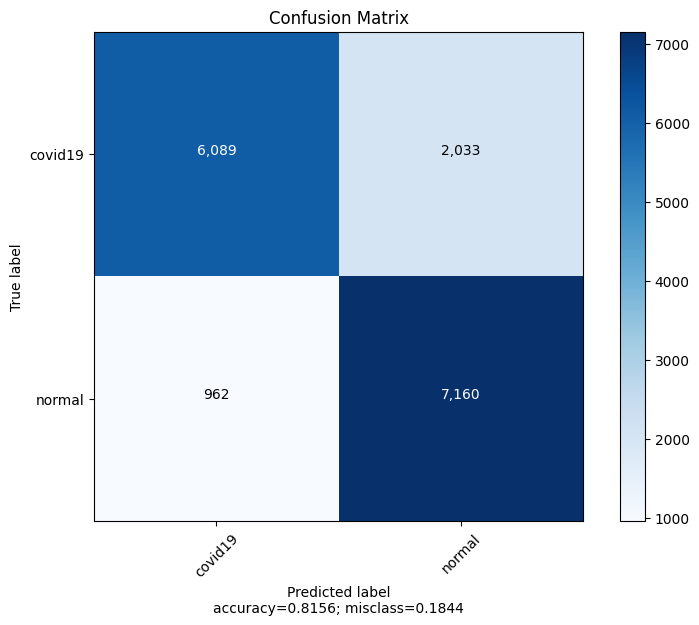

In [170]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(eval_true_list, eval_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['covid19','normal'],
                      title        = "Confusion Matrix")

In [171]:
torch.save(base_model.state_dict(), 'C:/Users/PC/Documents/0.Personal/FYP/FYP/Code/1_Model/Model_Ver4.pth')

In [99]:
import cv2
from torch.autograd import Variable

In [100]:
load_model = CNN_Model(pretrained=False)
load_model.to(torch.device('cuda'))
load_model.load_state_dict(torch.load('C:/Users/PC/Documents/0.Personal/FYP/FYP/Code/1_Model/Model_Ver4.pth', map_location='cuda'))
load_model.eval()
print('Inference Model Loaded on GPU')

Inference Model Loaded on GPU


In [101]:
EVALUATE_PATH = "C:/Users/PC/Documents/0.Personal/FYP/FYP/Code/coivd-overfilled"
# COVID_EVALUATE = "C:/Users/PC/Documents/0.Personal/FYP/FYP/Code/COVID-19 Lung CT Scans/2COVID"
# NORMAL_EVALUATE = "C:/Users/PC/Documents/0.Personal/FYP/FYP/Code/COVID-19 Lung CT Scans/1NonCOVID"


data = datasets.ImageFolder(EVALUATE_PATH, transform=test_transforms)
dataloader = torch.utils.data.DataLoader(data, batch_size=1)

classname = dataloader.dataset.classes

print(dataloader)
print(classname)

['1NonCOVID', '2COVID']


In [102]:
eval_pred_list = []
eval_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(dataloader, leave=True):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = load_model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        eval_pred_list.append(y_pred_tag.cpu().numpy())
        eval_true_list.append(y_batch.cpu().numpy())

  0%|          | 0/5120 [00:00<?, ?it/s]

In [103]:
evaluate_pred_list = [i[0] for i in eval_pred_list]
evaluate_true_list = [i[0] for i in eval_true_list]

In [104]:
print(classification_report(eval_true_list, eval_pred_list))

              precision    recall  f1-score   support

           0       0.74      0.77      0.75      2000
           1       0.85      0.82      0.84      3120

    accuracy                           0.80      5120
   macro avg       0.79      0.80      0.79      5120
weighted avg       0.80      0.80      0.80      5120



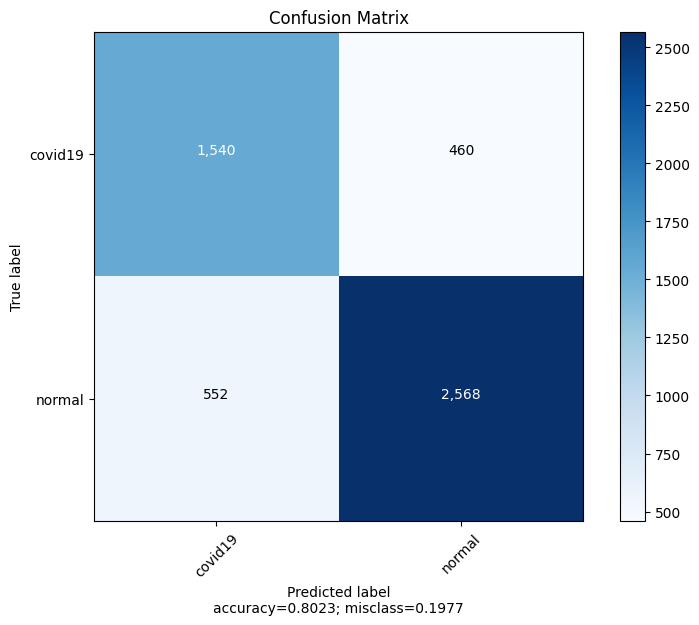

In [105]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(eval_true_list, eval_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['covid19','normal'],
                      title        = "Confusion Matrix")

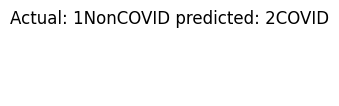

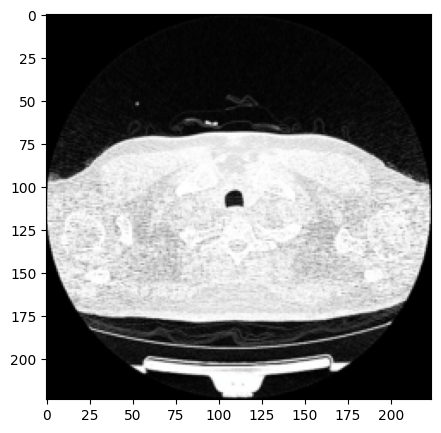

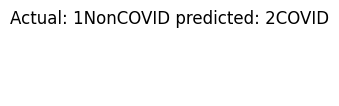

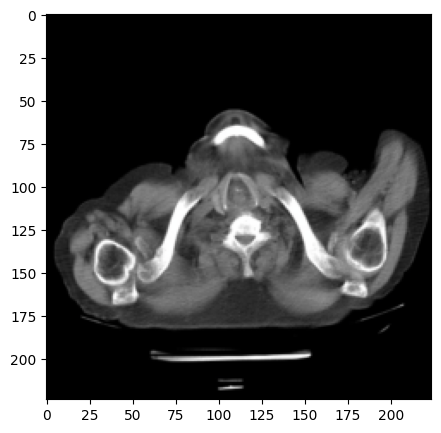

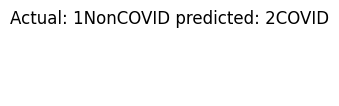

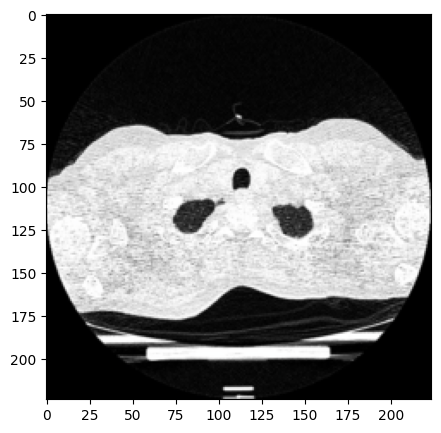

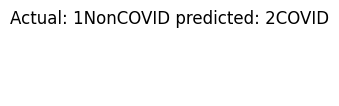

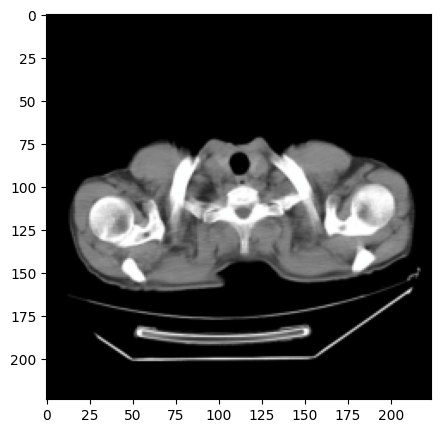

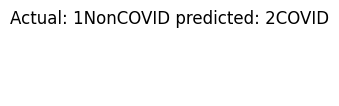

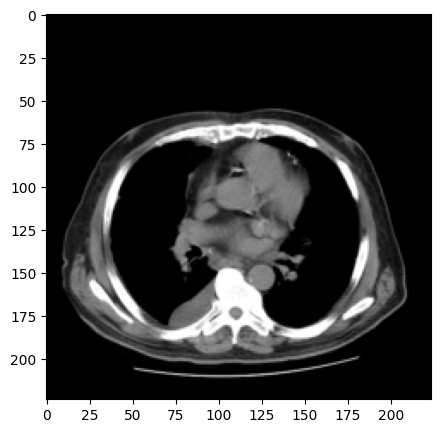

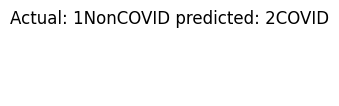

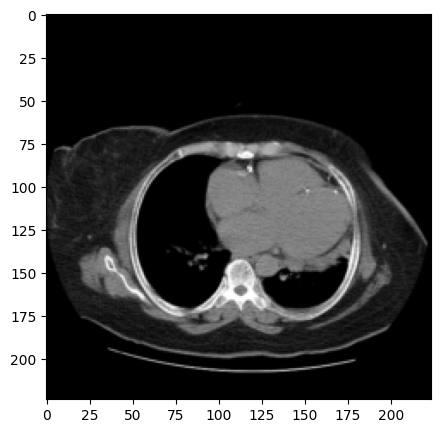

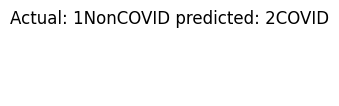

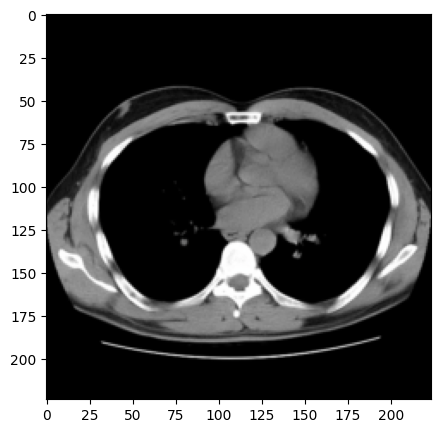

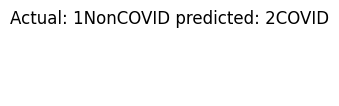

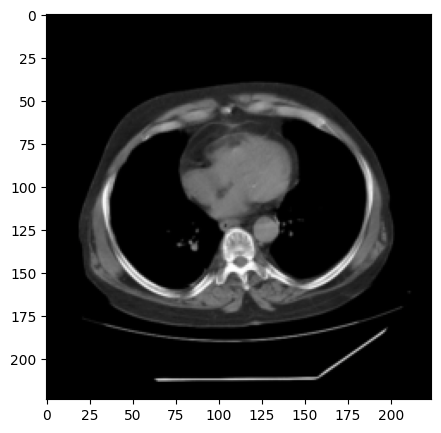

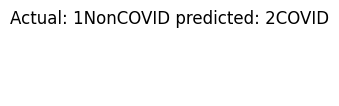

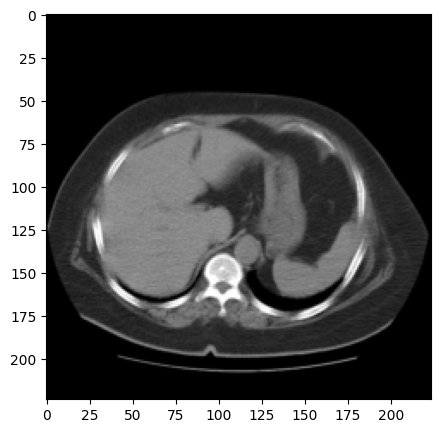

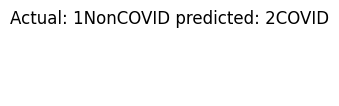

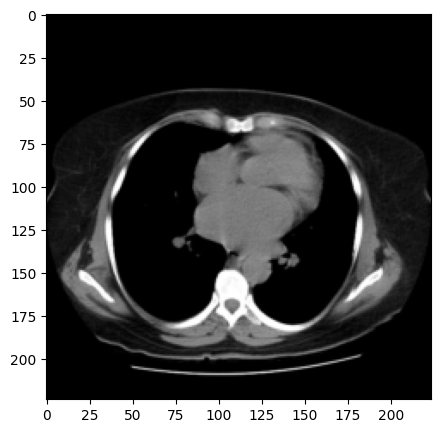

In [91]:
def predict_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

predict_model(load_model)
plt.show()

In [96]:
def predict(img_path):
    image = Image.open(img_path).convert("RGB")
    image_tensor = test_transforms(image)
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    # print(input.shape)
    input = input.to(torch.device('cuda'))
    out = load_model(input)
    _, preds = torch.max(out, 1)
    idx = preds.cpu().numpy()[0]
    pred_class = class_names[idx]
    score = out[0][0].item()
    plt.imshow(np.array(image))
    print("Predicted: {}".format(pred_class))


Predicted: 2COVID


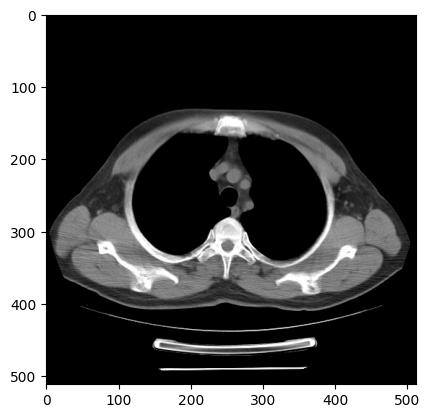

In [97]:
predict('C:/Users/PC/Documents/0.Personal/FYP/FYP/Code/coivd-overfilled/1NonCOVID/NegCov321.png')